In [1]:
import numpy as np
import pandas as pd
import bloscpack as bp

import imgaug as ia
import imgaug.augmenters as iaa

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import StratifiedKFold

from torch.utils.data.dataloader import DataLoader

import fastai
from fastai.vision import *
from fastai.callbacks import *

from optim import Over9000
from data import Bengaliai_DS

from callback_utils import SaveModelCallback
from mixup_fastai_utils import CmCallback, MuCmCallback, MixUpCallback
from loss import Loss_combine_weighted, Loss_combine_weighted_v2
from metric import Metric_grapheme, Metric_vowel, Metric_consonant, Metric_tot
from models_mg import Simple50GeM

---

In [2]:
SEED = 19841202

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

---
### data

In [3]:
augs = iaa.SomeOf(
    (0, 2),
    [
        iaa.SomeOf(
            (1, 2),
            [
                iaa.OneOf(
                    [
                        iaa.Affine(scale={"x": (0.8, 1.), "y": (0.8, 1.)}, rotate=(-15, 15), shear=(-15, 15)),
                        iaa.PerspectiveTransform(scale=.08, keep_size=True),
                    ]
                ),
                iaa.PiecewiseAffine(scale=.04),
            ],
            random_order=True
        ),
        iaa.DirectedEdgeDetect(alpha=(.6, .8), direction=(0.0, 1.0)),
    ],
    random_order=True
)

In [4]:
pdf = pd.read_csv('../input/train.csv')

In [5]:
unique_grapheme = pdf['grapheme'].unique()
grapheme_code = dict([(g, c) for g, c in zip(unique_grapheme, np.arange(unique_grapheme.shape[0]))])
pdf['grapheme_code'] = [grapheme_code[g] for g in pdf['grapheme']]

skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
for trn_ndx, vld_ndx in skf.split(pdf['grapheme_code'], pdf['grapheme_code']):
    break
    
trn_pdf = pdf.iloc[trn_ndx, :]
trn_pdf.reset_index(inplace=True, drop=True)
imgs = bp.unpack_ndarray_from_file('../features/train_images_size128_pad3.bloscpack')
lbls = pd.read_csv('../input/train.csv').iloc[:, 1:4].values

trn_imgs = imgs[trn_ndx]
trn_lbls = lbls[trn_ndx]
vld_imgs = imgs[vld_ndx]
vld_lbls = lbls[vld_ndx]

In [6]:
training_set = Bengaliai_DS(trn_imgs, trn_lbls, transform=augs)
validation_set = Bengaliai_DS(vld_imgs, vld_lbls)

training_loader = DataLoader(training_set, batch_size=64, num_workers=6, shuffle=True) # , sampler=sampler
validation_loader = DataLoader(validation_set, batch_size=64, num_workers=6, shuffle=False)

data_bunch = DataBunch(train_dl=training_loader, valid_dl=validation_loader)

---
### model

In [7]:
classifier = Simple50GeM()

In [8]:
logging_name = 'testing'

learn = Learner(
    data_bunch,
    classifier,
    loss_func=Loss_combine_weighted(),
    opt_func=Over9000,
    metrics=[Metric_grapheme(), Metric_vowel(), Metric_consonant(), Metric_tot()]
)

logger = CSVLogger(learn, logging_name)

learn.clip_grad = 1.0
# learn.split([classifier.cls])
learn.unfreeze()

In [9]:
learn.lr_find(start_lr=1e-05, end_lr=10., wd=1e-3)

epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


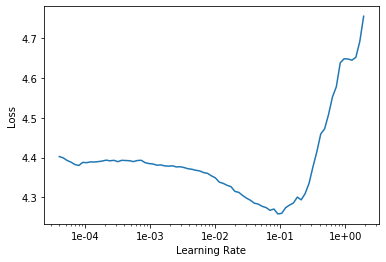

In [10]:
learn.recorder.plot()

In [11]:
3e-2

0.03

In [9]:
learn.fit_one_cycle(
    96,
    max_lr=1e-2,
    wd=0.,
    pct_start=0.0,
    div_factor=100,
    callbacks=[logger, SaveModelCallback(learn, monitor='metric_tot', mode='max', name=logging_name), MixUpCallback(learn)]
)

epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time
0,0.523705,0.303593,0.858036,0.931930,0.926014,0.893504,12:29


KeyboardInterrupt: 